# Spotting A Fake Job Posting
At first thought, fraudulent job postings don't seem to offer up much of a threat to society. However, cyber criminals are the ones creating these fraudulent postings in order to gain access to applicants' personal information. With this personal information, criminals can spoof identification cards, gain access to financial accounts, and even steal your identity.

Our goal for this project is to aid the defense for the harm that can be done by these fraudulent job postings. To do this, we're going to build logistic regression models that are capable of accurately predicting whether or not a job posting is fraudulent.
## Importing The Data
We'll import Pandas, NumPy, and a few other libraries that will help us explore our data and build our models.

In [54]:
# imports several useful libraries
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from itertools import chain, combinations

# reads our data into a data frame from our .csv file
df = pd.read_csv('fake_job_postings.csv')

## Initial Exploration
Our data contains both fraudulent and non-fraudulent postings. As we can see below, the non-fraudulent postings far outweigh the fraudulent postings. This is an indication that we'll have to undersample our data when making our models.

In [55]:
# finds the number and percentage of fraudulent postings in our data
fraud_rows = df['fraudulent'].sum()
total_rows = df.shape[0]
pct_fraud = ((fraud_rows / total_rows) * 100).round(2).astype(str) + '%'

print('Only', pct_fraud, 'of the postings in our data are fraudulent')

Only 4.84% of the postings in our data are fraudulent


Our data also has lots of cells with a value of `Null`. We can't create models with `Null` values in our data, so this is something we'll have to fix later as well.

In [56]:
# shows the number and percentage of null values for each column
for col in df.columns:
    null_rows = df[col].isnull().sum()
    null_pct = ((null_rows / total_rows) * 100).round(2).astype(str) + '%'
    print('{}: {} null values ({})'.format(col, null_rows, null_pct))

job_id: 0 null values (0.0%)
title: 0 null values (0.0%)
location: 346 null values (1.94%)
department: 11547 null values (64.58%)
salary_range: 15012 null values (83.96%)
company_profile: 3308 null values (18.5%)
description: 1 null values (0.01%)
requirements: 2695 null values (15.07%)
benefits: 7210 null values (40.32%)
telecommuting: 0 null values (0.0%)
has_company_logo: 0 null values (0.0%)
has_questions: 0 null values (0.0%)
employment_type: 3471 null values (19.41%)
required_experience: 7050 null values (39.43%)
required_education: 8105 null values (45.33%)
industry: 4903 null values (27.42%)
function: 6455 null values (36.1%)
fraudulent: 0 null values (0.0%)


In order to identify some general trends in our data, we'll break down the `Null` values visually.

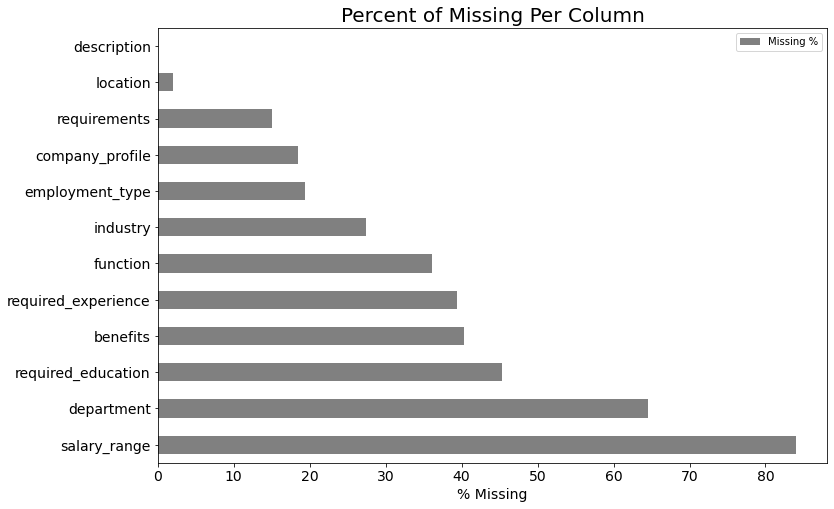

In [57]:
if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing %' : na_df})
        # plots our missing data
        missing_data.plot(kind = "barh",color='gray', figsize = (12, 8))
        # adjusts aesthetic elements
        plt.xlabel('% Missing', fontsize = 14)
        plt.title('Percent of Missing Per Column', fontsize = 20)
        plt.show()

For the whole dataset, the `salary_range` column appears to be missing the most values followed by `department` and `required_education`.

## Cleaning Our Data
In order to make prediction models, we need to fix some aspects of our data.

### Filling Null Values
In order to create models, we have to get rid of all `Null` values. In our case, we can't simply drop them because it would delete a large portion of our data. However, luckily for us all of the cells that have a `Null` value are of the `object` data type. So, we can just fill all of those cells with an empty string.

In [58]:
# fills null values in columns with an 'object' type with an empty string
for col in df.select_dtypes(include = 'object').columns:
    df[col] = df[col].fillna('')

Below we can see that we no longer have any `Null` values!

In [59]:
# shows the number and percentage of null values for each column
for col in df.columns:
    null_rows = df[col].isnull().sum()
    null_pct = ((null_rows / total_rows) * 100).round(2).astype(str) + '%'
    print('{}: {} null values ({})'.format(col, null_rows, null_pct))

job_id: 0 null values (0.0%)
title: 0 null values (0.0%)
location: 0 null values (0.0%)
department: 0 null values (0.0%)
salary_range: 0 null values (0.0%)
company_profile: 0 null values (0.0%)
description: 0 null values (0.0%)
requirements: 0 null values (0.0%)
benefits: 0 null values (0.0%)
telecommuting: 0 null values (0.0%)
has_company_logo: 0 null values (0.0%)
has_questions: 0 null values (0.0%)
employment_type: 0 null values (0.0%)
required_experience: 0 null values (0.0%)
required_education: 0 null values (0.0%)
industry: 0 null values (0.0%)
function: 0 null values (0.0%)
fraudulent: 0 null values (0.0%)


### Removing & Updating Columns
We can't create models using columns that have an `object` data type. Some of these columns contain long lines of text and others are just one word. For the long lines of text, we can create new columns that contain a word count of the text. However, the columns with one word in them are a little trickier. We can use `LabelEncoder` from `sklearn` to convert them to integers, but this is only useful if there isn't an absurd amount of unique values in the column. So, let's remove the columns with more than 20 unique values. We're also going to drop the `location` and `job_id` columns.

In [60]:
# initiates a list of all one word columns
one_word_cols = ['title', 'department', 'salary_range', 'employment_type', 'required_experience',
                'required_education', 'industry', 'function']

# goes through the list and drops the ones with a high amount of unique values
for col in one_word_cols:
    unique_values = df[col].nunique()
    if unique_values > 20:
        df = df.drop(col, axis = 1)

# drops other columns we don't need
df = df.drop(['location', 'job_id'], axis = 1)

Great! We are left with the `employment_type`, `required_experience`, and `required_education` columns. Now we can use `LabelEncoder` to convert our strings to integers.

In [61]:
le = LabelEncoder()
encode_cols = ['employment_type', 'required_experience', 'required_education']

for col in encode_cols:
    df[col] = le.fit_transform(df[col])

Now that that's done, we can convert the paragraph columns to a word count.

In [62]:
paragraph_cols = ['company_profile', 'description', 'requirements', 'benefits']

for col in paragraph_cols:
    df[col] = df[col].str.split().str.len()

Our data is now ready to be fit to models. Here's a visual of our word counts for further understanding.

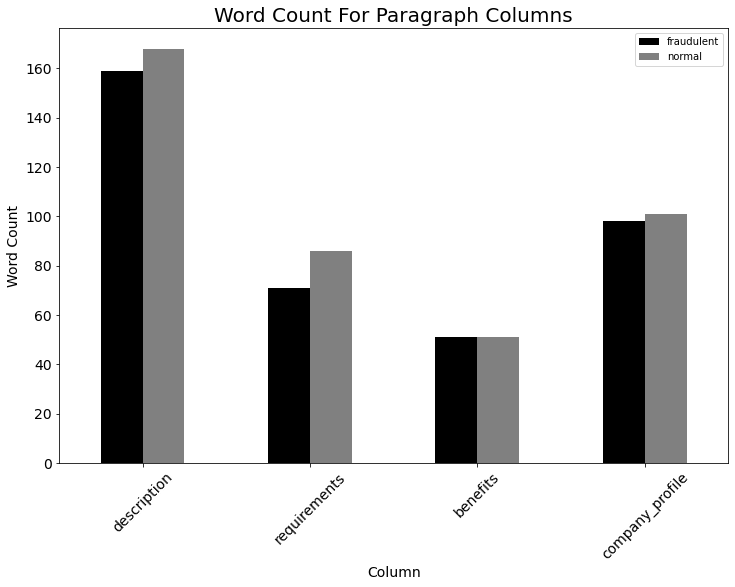

In [63]:
counts = {'fraudulent': [159,71,51,98],
          'normal': [168,86,51,101],
          'count_type': ['description','requirements','benefits','company_profile']
}

df_counts = pd.DataFrame(counts)
df_counts.plot(x = 'count_type',
               kind = 'bar',
               stacked = False,
               color = ['k','gray'],
               figsize = (12, 8))
plt.xticks(rotation = 45)
plt.xlabel('Column', fontsize = 14)
plt.ylabel('Word Count', fontsize = 14)
plt.title('Word Count For Paragraph Columns', fontsize = 20)
plt.show()

## Building Models
As mentioned earlier, we're going to have to undersample our data to ensure that our models are making the most accurate predictions possible. We're also going to split our undersampled data into training and testing sets.

In [64]:
clf = LogisticRegression(max_iter = 1000)

# splits our data into two data frames with an equal amount of fraud/non-fraud postings
fraud_df = df[df['fraudulent'] == 1]
nonfraud_df = df[df['fraudulent'] == 0].sample(fraud_df.shape[0])

# combines our new data frames together
new_df = pd.concat([fraud_df, nonfraud_df])

# creates a training and testing set of data
train_df, test_df = train_test_split(new_df, test_size = 0.3)

Now, we can start to get a better idea of what columns we want to make use of in our predictions. Let's look at the correlation coefficients to see if any columns stand out.

In [65]:
# shows correlation values for the fraudulent column
new_df.corr()['fraudulent']

company_profile       -0.407200
description           -0.049692
requirements          -0.152237
benefits               0.005488
telecommuting          0.063765
has_company_logo      -0.476072
has_questions         -0.243164
employment_type       -0.015375
required_experience   -0.089710
required_education     0.037520
fraudulent             1.000000
Name: fraudulent, dtype: float64

The columns that stand out the most appear to be `company_profile` and `has_company_logo`. Let's make our first models according to these columns. In order to make building these models easier, we'll define a new function that will do it for us.

In [66]:
def model(X_train, X_test, y_train, y_test, name):
    clf.fit(X_train, y_train)
    print('{}: {}'.format(name, clf.score(X_test,y_test).round(2)))
    print(classification_report(y_test, clf.predict(X_test)))

### The LoCoPro Model
Let's use our new function to create models for the Logo and Company Profile columns.

In [67]:
y_train = train_df['fraudulent']
y_test = test_df['fraudulent']

X1_train = train_df['has_company_logo'].values.reshape(-1, 1)
X1_test = test_df['has_company_logo'].values.reshape(-1, 1)
X2_train = train_df['company_profile'].values.reshape(-1, 1)
X2_test = test_df['company_profile'].values.reshape(-1, 1)

model(X1_train, X1_test, y_train, y_test, 'Logo')
model(X2_train, X2_test, y_train, y_test, 'Company Profile')

Logo: 0.71
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       240
           1       0.78      0.66      0.71       280

    accuracy                           0.71       520
   macro avg       0.72      0.72      0.71       520
weighted avg       0.72      0.71      0.71       520

Company Profile: 0.69
              precision    recall  f1-score   support

           0       0.66      0.65      0.66       240
           1       0.71      0.71      0.71       280

    accuracy                           0.69       520
   macro avg       0.68      0.68      0.68       520
weighted avg       0.69      0.69      0.69       520



As the classification reports show us, the Logo Model has a higher score and has a higher precision when predicting fraudulent postings. However, the Company Profile Model has a higher precisions when predicting non-fraudulent postings. Let's try combining these columns to see if we can get a better model.

In [68]:
X3_train = train_df[['has_company_logo', 'company_profile']]
X3_test = test_df[['has_company_logo', 'company_profile']]


model(X3_train, X3_test, y_train, y_test, 'Logo/Company Profile')

Logo/Company Profile: 0.71
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       240
           1       0.78      0.66      0.71       280

    accuracy                           0.71       520
   macro avg       0.72      0.72      0.71       520
weighted avg       0.72      0.71      0.71       520



Great! Our combined model is very slightly better than either of the columns working on their own. Now let's look at the probabilities our model was dealing with while predicting.

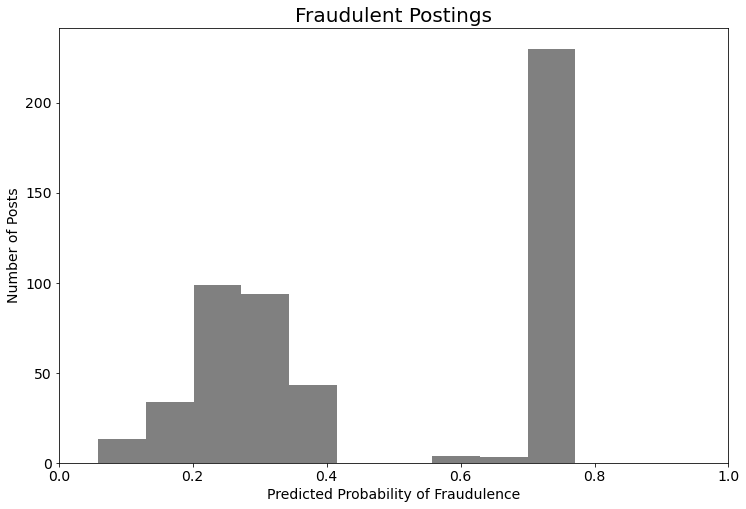

In [69]:
# creates a new dataframe of the predicted probabilities of shots
fraud_df = pd.DataFrame(clf.predict_proba(X3_test))
fraud_df.columns = ['non_fraudulent', 'fraudulent']

# plots the requested information
import matplotlib.pyplot as plt
fig2 = plt.figure(figsize = (12, 8))
plt.hist(x = fraud_df['fraudulent'], color = 'gray', bins = 10)
plt.xlim([0, 1])
plt.title('Fraudulent Postings', fontsize = 20)
plt.xlabel('Predicted Probability of Fraudulence', fontsize = 14)
plt.ylabel('Number of Posts', fontsize = 14)
plt.tick_params(axis = 'x', labelsize = 14)
plt.tick_params(axis = 'y', labelsize = 14)

plt.show()

Our plot indicates that the Logo/Company Profile Model makes some correct predictions when the predicted probability is below 50%. However, the model's confidence skyrockets when the predicted probability is over 70%, with over 200 occurrences of that happening.

Our original goal was to accurately weed out fraudulent job postings using a logistic regression model. As demonstrated above, the model constructed has done just that and could be put to use to prevent cyber criminals from stealing personal information in the future.

In [70]:
# exports our data
df.to_csv('cleaned_job_postings.csv')
new_df.to_csv('equal_job_postings.csv')